In [1]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Metadata processing

In [2]:
tracks = pd.read_csv('fma_metadata/raw_tracks.csv',index_col=0)
genres = pd.read_csv('fma_metadata/genres.csv', index_col=0)
audio_dir = 'fma_small'

#Get track ids for audio clips in dataset
def get_track_ids(audio_dir):
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        tids.extend([int(file[:-4]) for file in files])
        #if dirnames == []:
        #    tids.extend(int(file[:-4]) for file in files if ''.join(file[-4:])=='.mp3')
    return tids

clips_tids = set(get_track_ids(audio_dir))

#metadata is for full dataset; filter accordingly

tracks = tracks[tracks.index.isin(clips_tids)]

import ast

#tracks = tracks[pd.notnull(tracks['track_genres'])]

tracks['track_genres'] = tracks['track_genres'].apply(lambda x: ast.literal_eval(x)[0])

#get the top level genre for each track
def get_toplevel_genre(genre_id):
    top_level_id = genres.loc[genre_id]['top_level']
    return genres.loc[top_level_id]['title']

genre_ids = tracks['track_genres'].apply(lambda x: x['genre_id'])

tracks['toplevel_name'] = genre_ids.apply(lambda x: get_toplevel_genre(int(x)))

In [3]:
tracks.columns

Index(['album_id', 'album_title', 'album_url', 'artist_id', 'artist_name',
       'artist_url', 'artist_website', 'license_image_file',
       'license_image_file_large', 'license_parent_id', 'license_title',
       'license_url', 'tags', 'track_bit_rate', 'track_comments',
       'track_composer', 'track_copyright_c', 'track_copyright_p',
       'track_date_created', 'track_date_recorded', 'track_disc_number',
       'track_duration', 'track_explicit', 'track_explicit_notes',
       'track_favorites', 'track_file', 'track_genres', 'track_image_file',
       'track_information', 'track_instrumental', 'track_interest',
       'track_language_code', 'track_listens', 'track_lyricist',
       'track_number', 'track_publisher', 'track_title', 'track_url',
       'toplevel_name'],
      dtype='object')

In [4]:
#locate the audio file for each track_id; build a reference dictionary
track_dict = {}

def locate_tracks(track_ids, audio_dir):
    global track_dict
    track_set = set(track_ids)
    for _, dirnames, files in os.walk(audio_dir):
        for x in set(files):
            if int(x[:-4]) in track_set:
                track_dict[int(x[:-4])] = os.path.join(_, x)
                #return os.path.join(_, x)
    return None

locate_tracks(tracks.index, audio_dir)

In [5]:
#Read audio data from files

#Using ffmpeg

import numpy as np
import subprocess as sp
import librosa

a = '/home/ubuntu/kojak/fma_small/001/001039.mp3'

duration = 30

def get_waveform(filename, mono=True, duration=30, delay=0, sr=22050):
    if mono:
        n_channels = 1
    else:
        n_channels = 2 # n_channels: 2 for stereo, 1 for mono
    
    command = [ 'ffmpeg',
            '-i', filename,
            '-f', 's16le',
            '-ss', str(delay),
            '-t', str(duration),
            '-acodec', 'pcm_s16le',
            '-ar', str(sr),
            '-ac', str(n_channels),
            '-']
    proc = sp.run(command, stdout=sp.PIPE, bufsize=duration*sr, stderr=None, check=False) #stderr=sp.DEVNULL
    audio_array = np.fromstring(proc.stdout, dtype="int16")
    
    audio_array = librosa.util.normalize(audio_array)
    
    return audio_array, sr

a, sr = get_waveform(a)

from IPython.display import Audio

Audio(a, rate=sr)

# Generator object

In [6]:
labels = tracks['toplevel_name']

In [8]:
#New generator object
from keras.preprocessing import sequence
import audioread


from sklearn.utils import shuffle
import subprocess
from subprocess import CalledProcessError

maxlen = int(sr)*duration
batch_size = 4

from itertools import cycle

def sound_generator_batch(track_train, label_train, audio_dir, maxlen, mono=True):
    track_train, label_train = shuffle(track_train, label_train)
    i = 0
    while i < len(track_train):
        track_file = track_dict[track_train[i]]

        x, sr = get_waveform(track_file, mono)
        y = label_train.iloc[i]

        #reshape and pad the audio form
        x = x.reshape(1, x.shape[0], 1)
        x = sequence.pad_sequences(x, maxlen=maxlen, truncating='pre', padding='post', dtype=float)

        x = np.reshape(x,(int(np.median(x.shape)), min(x.shape), max(x.shape)))

        i += 1
        yield x,y

next(sound_generator_batch(labels.index, labels, audio_dir, maxlen, True))[1]

#write contents to files so we can extract later?

'Hip-Hop'

# Scan MFCC Data

In [9]:
from librosa.effects import harmonic
from librosa.effects import hpss
from librosa.feature import spectral_contrast
from scipy.stats import skew, kurtosis


def get_harm(data, n=13):
    y_harm, y_perc = hpss(data)
    return np.concatenate((get_mfcc(y_harm, n), get_mfcc(y_perc, n), get_spect(data)))

def get_mfcc(data, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=n_mfcc, n_fft = 2048, hop_length=512, n_mels=40, power=2.0)
    
    mean = np.mean(mfcc, axis=1)
    var = np.std(mfcc, axis=1)
    
    derv = np.gradient(mfcc, axis=1)
    derv2 = np.gradient(derv, axis=1)
    
    derv_mean = np.mean(derv,axis=1)
    derv_var = np.std(derv,axis=1)
    
    derv2_mean = np.mean(derv2,axis=1)
    derv2_var = np.std(derv2,axis=1)
    
    ret = np.concatenate((mean,var,derv_mean, derv_var, derv2_mean, derv2_var))
    return ret

def get_spect(data):
    spec_cont = spectral_contrast(data)
    
    mean = np.mean(spec_cont,axis=1)
    var = np.std(spec_cont, axis=1)
    
    derv = np.gradient(spec_cont, axis=1)
    derv2 = np.gradient(derv, axis=1)
    
    derv_mean = np.mean(derv,axis=1)
    derv_var = np.std(derv,axis=1)
    
    derv2_mean = np.mean(derv2,axis=1)
    derv2_var = np.std(derv2,axis=1)
    
    ret = np.concatenate((mean,var,derv_mean, derv_var, derv2_mean, derv2_var, \
                          skew(spec_cont, axis=1), kurtosis(spec_cont, axis=1)))
    return ret

In [ ]:
x_tot = []
y_tot = []

gen = sound_generator_batch(labels.index, labels, audio_dir, maxlen, True)

i = 0
for data in gen:
    x_tot.append(get_harm(data[0][0][0][:]))
    y_tot.append(data[1])
    i += 1
    print(i)

In [ ]:
#load into dataframes and save
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame(x_tot)
labs = pd.Series(y_tot)

df.to_csv('mfcc_new.csv', index=False)
labs.to_csv('labels_new.csv', index=False)

# Load data and build model

In [155]:
from sklearn.preprocessing import LabelEncoder
import os.path
import pandas

if os.path.isfile('mfcc_spect.csv'):
    df = pd.read_csv('mfcc_spect.csv', index_col=None)
if os.path.isfile('labels_spect.csv'):
    labs = pd.read_csv('labels_spect.csv', header=None, squeeze=True)

df['labels'] = labs
#df = df[df['labels'] != 'Pop'] #pop overlaps with multiple genres
#df = df[df['labels'] != 'Experimental'] #so does experimental
#df = df[df['labels'] != 'Folk'] #...and Folk
labs = df.pop('labels')

lbenc = LabelEncoder()
labs = lbenc.fit_transform(labs)

print(labs.shape)
print(df.shape)

#train/test split
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

(7997,)
(7997, 212)


# TSNE Plot

In [12]:
#run tsne so we can get a 2D visualization of clusters
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

tsne = TSNE(n_components=2, perplexity=50.0, n_iter=1000, metric='cosine')

pipe = make_pipeline(StandardScaler(), PCA(n_components=100), tsne)

df2 = df.copy()
df2['label'] = lbenc.inverse_transform(labs)
df2 = df2.sample(frac=0.4)

labs2 = df2.pop('label')
df2 = pd.DataFrame(pipe.fit_transform(df2))
df2['label'] = labs2

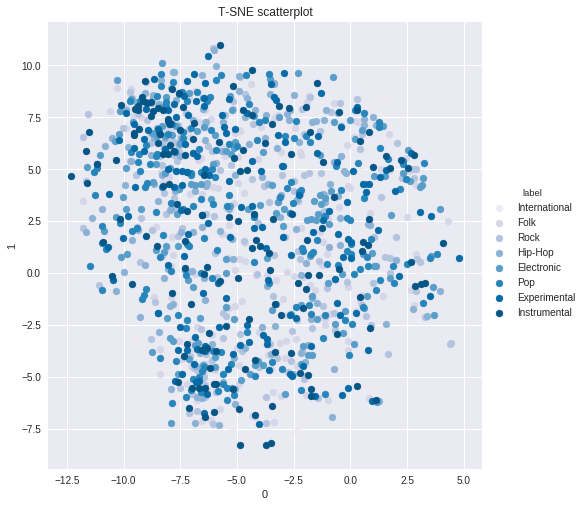

In [13]:
import seaborn as sns

fg = sns.FacetGrid(data=df2, hue='label', aspect=1, palette =sns.color_palette('PuBu', 8), size =7)
fg.map(plt.scatter, 0, 1).add_legend()

plt.title('T-SNE scatterplot')
plt.grid(linestyle='-', linewidth=1)

# No distinct patterns; can't really cluster by genre

# Clustering

Cluster numbers: 2
Cluster numbers: 3
Cluster numbers: 4
Cluster numbers: 5
Cluster numbers: 6
Cluster numbers: 7
Cluster numbers: 8
Cluster numbers: 9
Cluster numbers: 10
Cluster numbers: 11
Cluster numbers: 12
Cluster numbers: 13
Cluster numbers: 14
Cluster numbers: 15
Cluster numbers: 16
Cluster numbers: 17
Cluster numbers: 18
Cluster numbers: 19
Cluster numbers: 20
Cluster numbers: 21
Cluster numbers: 22
Cluster numbers: 23
Cluster numbers: 24


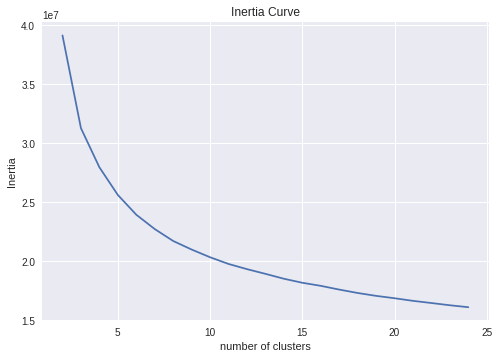

In [16]:
#Plot inertia curve for clusters to get the elbow

from sklearn.cluster import KMeans

Inertia = []
k_range = range(2,25)

for k in k_range:
    print('Cluster numbers: ' + str(k))
    km = KMeans(n_clusters=k)
    km.fit(df)
    Inertia.append(km.inertia_)

plt.plot(k_range, Inertia)
plt.xlabel('number of clusters')
plt.ylabel('Inertia');
plt.title('Inertia Curve')

In [173]:
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

n_clus=30

pipe = make_pipeline(StandardScaler(), PCA(n_components=100), KMeans(n_clusters=n_clus))

df2 = df.copy()

pipe.fit(df2)

df2['label'] = lbenc.inverse_transform(labs)
df2['cluster_num'] = pipe.steps[2][1].labels_

def mode_name(x):
    return x.value_counts().index[0]
def mode_count(x):
    return x.value_counts()[0]

def mode_name2(x):
    return x.value_counts().index[1]
def mode_count2(x):
    return x.value_counts()[1]

a = df2.groupby('cluster_num').agg({"label": [mode_name, mode_name2,\
                                                mode_count, mode_count2, 'count']}).reset_index()

a.head()

cluster_num          label                                            
                   mode_name     mode_name2 mode_count mode_count2 count
0           0  International   Experimental         64          20   122
1           1            Pop        Hip-Hop        106          86   508
2           2        Hip-Hop  International         55          26   130
3           3           Rock   Instrumental         35          29   152
4           4        Hip-Hop  International        208          33   326

# Supervised Model

In [156]:
df, labs = shuffle(df,labs)
x_train, x_test, y_train, y_test = train_test_split(df, labs, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#select model
svc = SVC(C=2, kernel='rbf', gamma = 1/2**7, probability = True) #gridsearch returned this feature combination

#pipeline
pipe2 = make_pipeline(StandardScaler(), TruncatedSVD(n_components=150), svc)

#train and evaluate
pipe2.fit(x_train, y_train)

from sklearn.metrics import accuracy_score
print('Train:', accuracy_score(y_train, pipe2.predict(x_train)))
y_pred = pipe2.predict(x_val)
print('Val:',accuracy_score(y_val, y_pred))
y_pred = pipe2.predict(x_test)
print('Test:', accuracy_score(y_test, y_pred))

#print ('CV:', np.mean(cross_val_score(pipe, x_train, y_train, cv=10, n_jobs=-1)))

Train: 0.965995700606
Val: 0.57890625
Test: 0.576875


In [18]:
sum(pipe.steps[1][1].explained_variance_ratio_)

0.93900971734425431

In [19]:
from sklearn.metrics import confusion_matrix

#row = predicted
#columns = actual

conf = confusion_matrix(y_test, y_pred)

confMat = pd.DataFrame(conf, index = lbenc.classes_, columns =lbenc.classes_)

#precision for each class
print('Precision:',np.diagonal(conf)/conf.sum(axis=1))
print('Recall:',np.diagonal(conf)/conf.sum(axis=0))
print('Accuracy:',np.sum(np.diagonal(conf))/conf.sum())

confMat

Precision: [ 0.61904762  0.44736842  0.65533981  0.60663507  0.5721393   0.62053571
  0.35519126  0.68877551]
Recall: [ 0.54166667  0.51829268  0.63981043  0.62745098  0.5721393   0.70558376
  0.36111111  0.59471366]
Accuracy: 0.574375


,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
Electronic,117,13,3,17,15,5,14,5
Experimental,12,85,10,13,25,12,19,14
Folk,4,5,135,4,14,15,19,10
Hip-Hop,40,7,0,128,6,6,14,10
Instrumental,12,23,18,3,115,2,14,14
International,11,6,18,21,4,139,13,12
Pop,17,19,17,14,12,12,65,27
Rock,3,6,10,4,10,6,22,135


In [20]:
np.round(conf/np.sum(conf,axis=0),2)

array([[ 0.54,  0.08,  0.01,  0.08,  0.07,  0.03,  0.08,  0.02],
       [ 0.06,  0.52,  0.05,  0.06,  0.12,  0.06,  0.11,  0.06],
       [ 0.02,  0.03,  0.64,  0.02,  0.07,  0.08,  0.11,  0.04],
       [ 0.19,  0.04,  0.  ,  0.63,  0.03,  0.03,  0.08,  0.04],
       [ 0.06,  0.14,  0.09,  0.01,  0.57,  0.01,  0.08,  0.06],
       [ 0.05,  0.04,  0.09,  0.1 ,  0.02,  0.71,  0.07,  0.05],
       [ 0.08,  0.12,  0.08,  0.07,  0.06,  0.06,  0.36,  0.12],
       [ 0.01,  0.04,  0.05,  0.02,  0.05,  0.03,  0.12,  0.59]])

In [59]:
#grid search for SVM

grid = {'C': [0.1, 2.0, 4.0, 8.0, 32.0]}
gcv = GridSearchCV(SVC(kernel='rbf'), grid, n_jobs=-1, cv=2, verbose=1)

pipe = make_pipeline(StandardScaler(), PCA(n_components=80), gcv)

#train and evaluate
pipe.fit(x_train, y_train)

pipe.steps[2][1].best_params_

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.7s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.3s finished


{'C': 2.0}

# Testing on other songs

In [145]:
# Single Genre

# load 30 seconds from an audio track of my choice

filename = 'songs/TakeOnMe.mp3'

tags = []

for i in range(3):
    #Get predictions for multiple sections of a song and return the mode of the predictions
    delay = i*45+30
    a, sr = get_waveform(filename, mono=True, duration=30, delay=delay, sr=22050)

    # feed it into the signal processing pipeline to get a feature vector
    vec = get_harm(a).reshape(1,-1)
    
    # run predictions on the feature vector
    tags.append(lbenc.inverse_transform(pipe2.predict(vec))[0])

    
max(set(tags), key=tags.count)

'Hip-Hop'

In [159]:
%%timeit -n 1 -r 1

# Predict top genres for a song

filename = 'songs/BohemianRhap.mp3'

tags = {}

delay = 90
a, sr = get_waveform(filename, mono=True, duration=30, delay=delay, sr=22050)
# feed it into the signal processing pipeline to get a feature vector
vec = get_harm(a).reshape(1,-1)

# run predictions on the feature vector
for i, score in enumerate(pipe2.predict_proba(vec)[0]):
    tags[lbenc.inverse_transform(i)] = score

# top 3
#print([i[0] for i in sorted([(key, val) for key, val in tags.items()], key=lambda x: x[1], reverse=True)[:3]])

# all significant categories that pass a certain threshold
print(sorted([(key, val) for key, val in tags.items() if val > 0.12], key=lambda x: x[1], reverse=True))
print(sorted([(key, val) for key, val in tags.items()], key=lambda x: x[1], reverse=True))

[('Pop', 0.35129842168876796), ('Experimental', 0.2784865037365768), ('Folk', 0.12598626874000385)]
[('Pop', 0.35129842168876796), ('Experimental', 0.2784865037365768), ('Folk', 0.12598626874000385), ('International', 0.10318959850227119), ('Rock', 0.062319939664037365), ('Instrumental', 0.034001107134808542), ('Electronic', 0.033912276845206257), ('Hip-Hop', 0.010805883688328386)]
1 loop, best of 1: 2.52 s per loop


# Pickle for later


In [160]:
import pickle as pkl

with open('model.pkl', 'wb') as output:
    pkl.dump([pipe2, lbenc], output)

# References

## Dataset

https://arxiv.org/pdf/1612.01840v2.pdf

## Signal Processing

http://research.ijcaonline.org/icict/number8/icict1483.pdf

MFCC statistics: https://arxiv.org/pdf/1703.09179.pdf

HPSS decomposition: http://ismir2010.ismir.net/proceedings/ismir2010-17.pdf